# Orbital Insight

Orbital Insight Energy provides access to global and regional crude oil volume estimates, monitoring over 5 billion barrels of oil storage capacity across more than 25,000 tanks. The data covers 48 months of historical storage site, country and regional level measurements as well as 49 regions, including OPEC and China.

For more information: http://www.cmegroup.com/market-data/orbital-insight.html

In this blog article, we will show how we can track crude oil futures price changes after crude oil storage volume changes using a simple Python methodology. This blog is written to introduce the format of both Orbital Insight and CME Group futures data and how it can be used for data analysis. This is not suggesting any trade ideas or strategies.

In [56]:
import pandas as pd
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Load CME Crude Oil Futures Settlement Prices
NYMEX WTI Crude Oil futures(CL) historical(1/2/18-present) settlement data

In [57]:
df_sett = pd.read_csv('./data/CrudeSettleHistorical.csv', index_col='Settlement Date', parse_dates=True )

In [58]:
df_sett.head()

,Product,Contract,Settlement
Settlement Date,,,
2013-01-02,CL,CLG13,93.12
2013-01-02,CL,CLH13,93.55
2013-01-02,CL,CLJ13,93.97
2013-01-02,CL,CLK13,94.33
2013-01-02,CL,CLM13,94.60


Futures markets generally use symbology to indicate a specific month and year a given contract will expire.  Learn about contract codes at https://www.investopedia.com/articles/active-trading/011515/quick-guide-futures-quotes.asp

In [59]:
# split contract month and product symbol from 'Contract' column and create 'Cont' column.
df_sett['Cont'] = df_sett['Contract'].str[-2:] + df_sett['Contract'].str[2]

In [60]:
df_sett.head()

,Product,Contract,Settlement,Cont
Settlement Date,,,,
2013-01-02,CL,CLG13,93.12,13G
2013-01-02,CL,CLH13,93.55,13H
2013-01-02,CL,CLJ13,93.97,13J
2013-01-02,CL,CLK13,94.33,13K
2013-01-02,CL,CLM13,94.60,13M


## Finding N-th Nearby Contract Month

Finding n-th nearby contract of each trading date is challenging with settlement data in flat format. In this section, we will find n-th nearby contract month and its settlement price without futures expiration schedule.   

In [61]:
sett_pivot = pd.pivot_table(df_sett, index=df_sett.index, columns='Cont', values='Settlement')

In [62]:
sett_pivot.head()

Cont,13G,13H,13J,13K,13M,13N,13Q,13U,13V,13X,...,26K,26M,26N,26Q,26U,26V,26X,26Z,27F,27G
Settlement Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,93.12,93.55,93.97,94.33,94.60,94.76,94.78,94.69,94.51,94.33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,92.92,93.34,93.76,94.12,94.39,94.55,94.56,94.46,94.27,94.07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-04,93.09,93.51,93.91,94.21,94.40,94.51,94.48,94.36,94.15,93.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-07,93.19,93.63,94.02,94.33,94.54,94.67,94.67,94.57,94.38,94.18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-08,93.15,93.60,94.02,94.38,94.65,94.81,94.84,94.77,94.62,94.44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Finding N-th nearby contract for each trading date from the pivot table

In [63]:
# function: getting n-th nearby contract settlement price

def n_nearby(x,n):
    if x.first_valid_index() is None:
        return None
    else:
        return x[x.index[x.index.get_loc(x.first_valid_index())+n]]

In [64]:
# function: getting n-th nearby contract settlement price and contract month

def n_nearby_mon(x,n):
    if x.first_valid_index() is None:
        return None
    else:
        return x[x.index[x.index.get_loc(x.first_valid_index())+n]], x.index[x.index.get_loc(x.first_valid_index())+n]

In [65]:
# front month contract price
sett_pivot['N1'] = sett_pivot.apply(lambda row: n_nearby(row,0), axis=1)

# 2nd nearby contract price
sett_pivot['N2'] = sett_pivot.apply(lambda row: n_nearby(row,1), axis=1)

# 3rd nearby contract price
sett_pivot['N3'] = sett_pivot.apply(lambda row: n_nearby(row,2), axis=1)

# 6th nearby contract price
sett_pivot['N6'] = sett_pivot.apply(lambda row: n_nearby(row,5), axis=1)

# You can continue to do this for any contract months your trying to pull into your analysis.

The resulting output from this step is the nearest expiration month of crude oil (N1), the next nearest month (N2), the third nearest month (N3), and the sixth nearest month (N6) 

In [66]:
sett_pivot[['N1','N2','N3','N6']].head()

Cont,N1,N2,N3,N6
Settlement Date,,,,
2013-01-02,93.12,93.55,93.97,94.76
2013-01-03,92.92,93.34,93.76,94.55
2013-01-04,93.09,93.51,93.91,94.51
2013-01-07,93.19,93.63,94.02,94.67
2013-01-08,93.15,93.60,94.02,94.81


Now let's pair the nearest month prices with the respective contract indicators into a tuple

In [67]:
# getting 1~6 nearby contract months and prices
sett_pivot['1nb mon'] = sett_pivot.apply(lambda row: n_nearby_mon(row,0), axis=1)
sett_pivot['2nb mon'] = sett_pivot.apply(lambda row: n_nearby_mon(row,1), axis=1)
sett_pivot['3nb mon'] = sett_pivot.apply(lambda row: n_nearby_mon(row,2), axis=1)
sett_pivot['6nb mon'] = sett_pivot.apply(lambda row: n_nearby_mon(row,5), axis=1)

You can see on the 23rd of January, the nearest month switched from February (G) to March (H).  The second, third and sixth nearby months also shift accordingly.

In [68]:
sett_pivot[['1nb mon','2nb mon','3nb mon','6nb mon']][12:16]

Cont,1nb mon,2nb mon,3nb mon,6nb mon
Settlement Date,,,,
2013-01-18,"(95.56, 13G)","(96.04, 13H)","(96.43, 13J)","(97.0, 13N)"
2013-01-22,"(96.24, 13G)","(96.68, 13H)","(97.07, 13J)","(97.68, 13N)"
2013-01-23,"(95.23, 13H)","(95.75, 13J)","(96.21, 13K)","(96.58, 13Q)"
2013-01-24,"(95.95, 13H)","(96.45, 13J)","(96.9, 13K)","(97.31, 13Q)"


The following plot shows each of the nearby contracts.  Notice these generally follow each other in a very consistent pattern.  The difference between the first nearby and the second nearby is called a 'Calendar Spread'.  

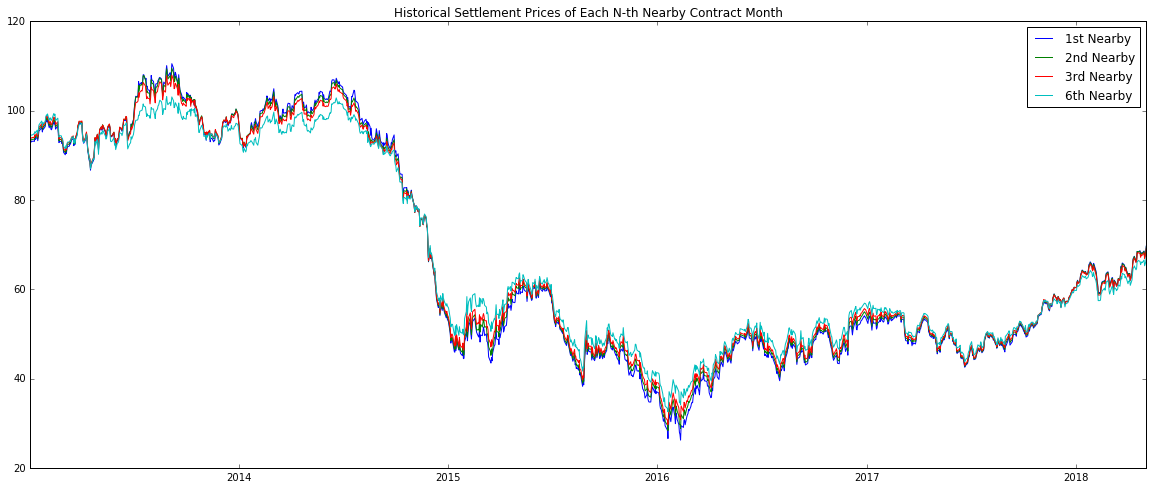

In [69]:
plt.rcParams['figure.figsize'] = 20,8
plt.title('Historical Settlement Prices of Each N-th Nearby Contract Month');
plt.plot(sett_pivot[['N1','N2','N3','N6']]);
plt.legend(['1st Nearby', '2nd Nearby','3rd Nearby','6th Nearby']);


This plot shows the spread between the first and third nearby months.  

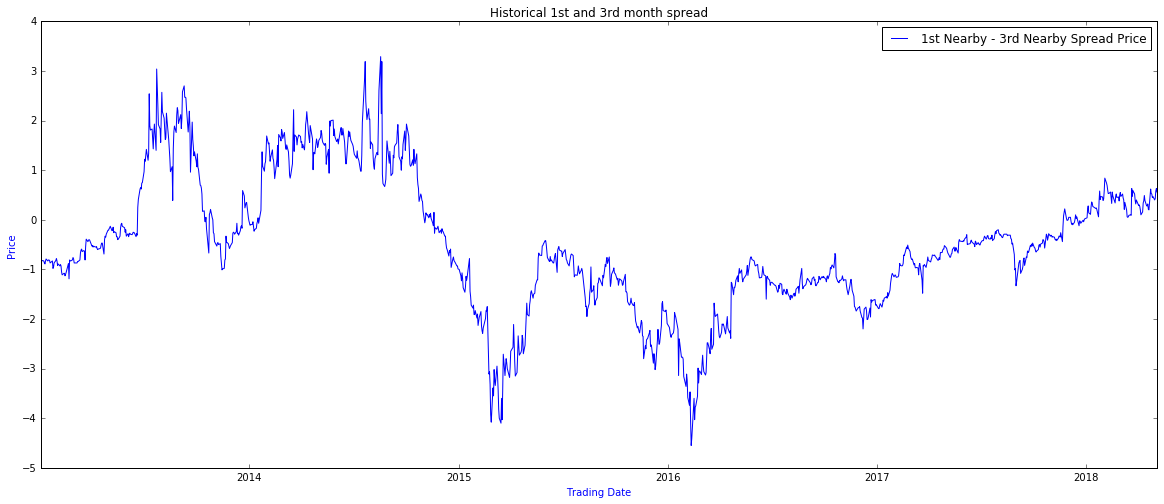

In [70]:
plt.plot(sett_pivot['N1'] - sett_pivot['N3']);
plt.title('Historical 1st and 3rd month spread');
plt.xlabel('Trading Date', color='b');
plt.ylabel('Price', color='b');
plt.legend(['1st Nearby - 3rd Nearby Spread Price'])
plt.rcParams['figure.figsize'] = 20,8

Now we can find n-th nearby contracts from flat settlement data using functions above. We will use those for Orbital Insight data analysis in the next section 

In [71]:
# concise dataframe from pivot table 
price_df = pd.DataFrame(sett_pivot[['1nb mon','2nb mon','3nb mon','6nb mon']])
price_df['date'] = price_df.index
price_df = price_df.reset_index(drop=True)
price_df['index'] = price_df.index
price_df.head(10)

Cont,1nb mon,2nb mon,3nb mon,6nb mon,date,index
0,"(93.12, 13G)","(93.55, 13H)","(93.97, 13J)","(94.76, 13N)",2013-01-02,0
1,"(92.92, 13G)","(93.34, 13H)","(93.76, 13J)","(94.55, 13N)",2013-01-03,1
2,"(93.09, 13G)","(93.51, 13H)","(93.91, 13J)","(94.51, 13N)",2013-01-04,2
3,"(93.19, 13G)","(93.63, 13H)","(94.02, 13J)","(94.67, 13N)",2013-01-07,3
4,"(93.15, 13G)","(93.6, 13H)","(94.02, 13J)","(94.81, 13N)",2013-01-08,4
5,"(93.1, 13G)","(93.56, 13H)","(93.99, 13J)","(94.87, 13N)",2013-01-09,5
6,"(93.82, 13G)","(94.27, 13H)","(94.65, 13J)","(95.33, 13N)",2013-01-10,6
7,"(93.56, 13G)","(93.99, 13H)","(94.35, 13J)","(94.98, 13N)",2013-01-11,7
8,"(94.14, 13G)","(94.59, 13H)","(94.97, 13J)","(95.65, 13N)",2013-01-14,8
9,"(93.28, 13G)","(93.72, 13H)","(94.09, 13J)","(94.68, 13N)",2013-01-15,9


### Tracking settlement prices in x-days for a certain contract

Since a contract expires every month, simply shifting rows will not work here to track prices in x-days

In [72]:
# function: finding settlement price a day prior
def prior_price(x,a,n):
    return sett_pivot[x[str(a)+'nb mon'][1]][x['index']-n]
    
    

In [73]:
# function: finding settlement price a day after
def after_price(x,a,n):
    if x['index']+n > len(price_df)-n:
        return None
    else:
        return sett_pivot[x[str(a)+'nb mon'][1]][x['index']+n]

Tracking settlement prices for various contracts

In [74]:
n=10 # n prior day
a=1 # a nearby month
price_df[str(a) + 'nb_' + str(n) + 'days'] = price_df.apply(lambda row: after_price(row,a,n), axis=1)
price_df[str(a) + 'nb_price'] = price_df[str(a) +'nb mon'].apply(lambda x: x[0])

n=10 # n prior day
a=2 # a nearby month
price_df[str(a) + 'nb_' + str(n) + 'days'] = price_df.apply(lambda row: after_price(row,a,n), axis=1)
price_df[str(a) + 'nb_price'] = price_df[str(a) +'nb mon'].apply(lambda x: x[0])

n=10 # n prior day
a=3 # a nearby month
price_df[str(a) + 'nb_' + str(n) + 'days'] = price_df.apply(lambda row: after_price(row,a,n), axis=1)
price_df[str(a) + 'nb_price'] = price_df[str(a) +'nb mon'].apply(lambda x: x[0])

n=20 # n prior day
a=2 # a nearby month
price_df[str(a) + 'nb_' + str(n) + 'days'] = price_df.apply(lambda row: after_price(row,a,n), axis=1)
price_df[str(a) + 'nb_price'] = price_df[str(a) +'nb mon'].apply(lambda x: x[0])

n=20 # n prior day
a=3 # a nearby month
price_df[str(a) + 'nb_' + str(n) + 'days'] = price_df.apply(lambda row: after_price(row,a,n), axis=1)
price_df[str(a) + 'nb_price'] = price_df[str(a) +'nb mon'].apply(lambda x: x[0])

n=40 # n prior day
a=3 # a nearby month
price_df[str(a) + 'nb_' + str(n) + 'days'] = price_df.apply(lambda row: after_price(row,a,n), axis=1)
price_df[str(a) + 'nb_price'] = price_df[str(a) +'nb mon'].apply(lambda x: x[0])

n=40 # n prior day
a=6 # a nearby month
price_df[str(a) + 'nb_' + str(n) + 'days'] = price_df.apply(lambda row: after_price(row,a,n), axis=1)
price_df[str(a) + 'nb_price'] = price_df[str(a) +'nb mon'].apply(lambda x: x[0])


In [75]:
# calculating price changes
price_df['1nb_chg_10days'] = price_df['1nb_10days'] - price_df['1nb_price']
price_df['2nb_chg_10days'] = price_df['2nb_10days'] - price_df['2nb_price']
price_df['3nb_chg_10days'] = price_df['3nb_10days'] - price_df['3nb_price']

# some 1nb_price doesn't exist anymore in 20 days. So, 1nb_price is excluded from tracking prices in 20 days 
price_df['2nb_chg_20days'] = price_df['2nb_20days'] - price_df['2nb_price']
price_df['3nb_chg_20days'] = price_df['3nb_20days'] - price_df['3nb_price']

# some 2nb_price doesn't exist anymore in 40 days. So, 2nb_price is excluded from tracking prices in 40 days
price_df['3nb_chg_40days'] = price_df['3nb_40days'] - price_df['3nb_price']
price_df['6nb_chg_40days'] = price_df['6nb_40days'] - price_df['6nb_price']


Resampling data (converting daily into weekly)

In [76]:
price_df.index = pd.DatetimeIndex(price_df['date'])
price_resample = price_df.resample('W').first()

In [77]:
price_df.head(5)

Cont,1nb mon,2nb mon,3nb mon,6nb mon,date,index,1nb_10days,1nb_price,2nb_10days,2nb_price,...,3nb_40days,6nb_40days,6nb_price,1nb_chg_10days,2nb_chg_10days,3nb_chg_10days,2nb_chg_20days,3nb_chg_20days,3nb_chg_40days,6nb_chg_40days
date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,"(93.12, 13G)","(93.55, 13H)","(93.97, 13J)","(94.76, 13N)",2013-01-02,0,94.24,93.12,94.68,93.55,...,90.68,91.86,94.76,1.12,1.13,1.08,3.94,3.99,-3.29,-2.90
2013-01-03,"(92.92, 13G)","(93.34, 13H)","(93.76, 13J)","(94.55, 13N)",2013-01-03,1,95.49,92.92,95.94,93.34,...,90.12,91.30,94.55,2.57,2.60,2.55,4.43,4.48,-3.64,-3.25
2013-01-04,"(93.09, 13G)","(93.51, 13H)","(93.91, 13J)","(94.51, 13N)",2013-01-04,2,95.56,93.09,96.04,93.51,...,90.82,92.00,94.51,2.47,2.53,2.52,2.66,2.75,-3.09,-2.51
2013-01-07,"(93.19, 13G)","(93.63, 13H)","(94.02, 13J)","(94.67, 13N)",2013-01-07,3,96.24,93.19,96.68,93.63,...,90.43,91.57,94.67,3.05,3.05,3.05,3.01,3.09,-3.59,-3.10
2013-01-08,"(93.15, 13G)","(93.6, 13H)","(94.02, 13J)","(94.81, 13N)",2013-01-08,4,NaN,93.15,95.23,93.60,...,91.56,92.62,94.81,NaN,1.63,1.73,3.02,3.07,-2.46,-2.19


In [78]:
price_resample.head(5)

Cont,1nb mon,2nb mon,3nb mon,6nb mon,date,index,1nb_10days,1nb_price,2nb_10days,2nb_price,...,3nb_40days,6nb_40days,6nb_price,1nb_chg_10days,2nb_chg_10days,3nb_chg_10days,2nb_chg_20days,3nb_chg_20days,3nb_chg_40days,6nb_chg_40days
date,,,,,,,,,,,,,,,,,,,,,
2013-01-06,"(93.12, 13G)","(93.55, 13H)","(93.97, 13J)","(94.76, 13N)",2013-01-02,0,94.24,93.12,94.68,93.55,...,90.68,91.86,94.76,1.12,1.13,1.08,3.94,3.99,-3.29,-2.90
2013-01-13,"(93.19, 13G)","(93.63, 13H)","(94.02, 13J)","(94.67, 13N)",2013-01-07,3,96.24,93.19,96.68,93.63,...,90.43,91.57,94.67,3.05,3.05,3.05,3.01,3.09,-3.59,-3.10
2013-01-20,"(94.14, 13G)","(94.59, 13H)","(94.97, 13J)","(95.65, 13N)",2013-01-14,8,NaN,94.14,97.57,94.59,...,92.52,93.26,95.65,NaN,2.98,3.02,2.92,3.10,-2.45,-2.39
2013-01-27,"(96.24, 13G)","(96.68, 13H)","(97.07, 13J)","(97.68, 13N)",2013-01-22,13,96.62,96.24,96.64,96.68,...,92.96,93.95,97.68,1.39,-0.04,0.04,-2.22,-1.85,-4.11,-3.73
2013-02-03,"(96.44, 13H)","(96.87, 13J)","(97.26, 13K)","(97.63, 13Q)",2013-01-28,17,97.03,96.44,97.58,96.87,...,96.34,96.68,97.63,0.59,0.71,0.85,-4.24,-4.21,-0.92,-0.95


# Orbital Insight Crude Oil Volume Estimate Data Outlook and Pattern

OI data is available in CME DataMine and accessible using API, FSTP and AWS S3 transfer.<br>
Data used: ORBITALINSIGHT_USA_paddall, 1/1/2014 - 6/5/2018. The numbers presented in the file have been randomly modified but for our purposes will not affect the outcome of this analysis. 

### Loading and Exploring Orbital Insight Data

In [79]:
df_oi = pd.read_csv('./data/ORBITALINSIGHT_USA_paddall_0_4_20180703_modified.csv', index_col='date', parse_dates=True )

In [80]:
df_oi.head()

,volume.estimate,smoothed.estimate,volume.estimate.stderr,storage.capacity.estimate,total.available.tanks,sampled.tanks,truth_value_mb
date,,,,,,,
2014-01-01,337.613942,NaN,8.618299,679.873814,3947,145,NaN
2014-01-02,334.726793,NaN,8.297105,679.873814,3947,364,NaN
2014-01-03,333.567292,NaN,7.765425,679.873814,3947,397,326.737
2014-01-04,334.447059,NaN,7.776826,679.873814,3947,400,NaN
2014-01-05,334.255716,NaN,8.187224,679.873814,3947,393,NaN


In [81]:
df_oi.columns

Index([u'volume.estimate', u'smoothed.estimate', u'volume.estimate.stderr',
       u'storage.capacity.estimate', u'total.available.tanks',
       u'sampled.tanks', u'truth_value_mb'],
      dtype='object')

Orbital Insight data has 8 columns; 

*  Date - date of estimate
*  Volume.estimate - estimate of crude oil in floating roof tank
*  Smoothed.estimate - moving average of volume.estimate
*  Volume.estimate.stderr - standard error for the volume estimate
*  Storage.capacity.estimate - total storage capacity for the tanks in the region
*  Total.available.tanks - total number of tanks in Orbiatal Insight coverage
*  Sampled.tanks - number of distinct tanks with observations that produced the volume.estimate
*  Truth_value_mb - government published storage reading (when available)

We will mainly use Volume.estimate in this analysis

In [82]:
df_oi.describe()

,volume.estimate,smoothed.estimate,volume.estimate.stderr,storage.capacity.estimate,total.available.tanks,sampled.tanks,truth_value_mb
count,1644.000000,1630.000000,1644.000000,1644.000000,1644.000000,1644.000000,234.000000
mean,366.356504,366.434133,4.951365,700.818498,4028.761557,1818.508516,436.069244
std,28.388540,28.332276,1.412913,13.792695,51.622551,1014.838576,60.270557
min,308.236259,309.605410,2.208253,679.873814,3947.000000,145.000000,319.079000
25%,339.641977,339.519736,3.778049,688.677532,3983.000000,806.500000,393.622750
50%,369.095227,368.681131,4.757575,695.686767,4011.000000,1770.000000,448.048500
75%,390.779251,391.449719,6.241106,714.664072,4082.000000,2741.750000,485.454250
max,415.292512,411.417274,8.618299,724.163202,4111.000000,3676.000000,535.543000


### Graph of the raw data

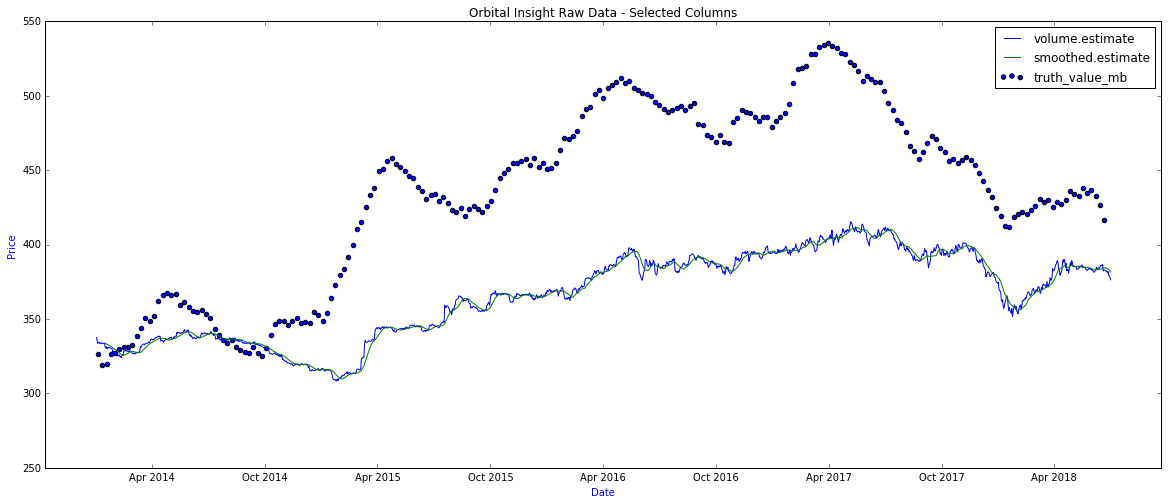

In [83]:
plt.plot(df_oi[['volume.estimate','smoothed.estimate']]);
plt.scatter(df_oi.index,df_oi['truth_value_mb']);

plt.title('Orbital Insight Raw Data - Selected Columns')
plt.xlabel('Date', color='b');
plt.ylabel('Price', color='b');
plt.legend(df_oi[['volume.estimate','smoothed.estimate','truth_value_mb']])
plt.rcParams['figure.figsize'] = 20,8

### Orbital Insight and CME Settlement Data

In this section, with Orbital Insight and CME crude oil settlement prices, we will track how crude oil futures price changes after Orbital Insight changes significantly. Specifically, we will see the direction of price change in 40 business days (about 2 months) when the weekly average of Orbital Insight changes significantly.  

In [84]:
#Take key pricing fields from our first section.
df_final = price_resample[['1nb_chg_10days','2nb_chg_10days','3nb_chg_10days','2nb_chg_20days','3nb_chg_20days','3nb_chg_40days'\
                           ,'6nb_chg_40days']]

#append Orbital Insights Data sampled on the same index.
df_final[['smoothed.estimate','truth_value_mb','volume.estimate']] = df_oi[['smoothed.estimate','truth_value_mb',\
                                                                            'volume.estimate']].resample('W').mean()

#generate rolling 5 week averages of the volumne.estimate field.
df_final.loc[:,'rolling'] = df_final['volume.estimate'].rolling(window=5, min_periods=1).mean()

#generate the week to week change in the rolling average.
df_final.loc[:,'oi_change'] = df_final['volume.estimate'] - df_final['volume.estimate'].shift(1)

###
#Generate a difference between the current weeks estimate and the rolling average 
#that will be our primary trade indicator
###
df_final.loc[:,'diff'] = df_final['volume.estimate'] - df_final['rolling']

In [85]:
# Selecting a valid timeframe with both crude oil prices and Orbital data available
df_final = df_final.loc['2014':'2018']

In [86]:
df_final[['rolling','oi_change','diff']].head()

Cont,rolling,oi_change,diff
date,,,
2014-01-05,334.922160,NaN,0.000000
2014-01-12,334.303527,-1.237267,-0.618633
2014-01-19,333.345922,-2.254181,-1.915209
2014-01-26,332.636973,-0.920588,-2.126848
2014-02-02,331.534398,-3.386025,-4.410299


In [87]:
# adding directions of price changes/volume estimate

# We want to track the price changes in 40 business days (about 2 months). The 3rd nearby contract is the closest contract which
# doesn't expire for the next 40 days

df_final['oi_chg_sign'] = np.sign(df_final['oi_change'].fillna(0))
df_final['price_chg_sign'] = np.sign(df_final['3nb_chg_40days'].fillna(0))

#filled NaN with zero since .sign returns a warning if NaN provided

We want to track the price changes in 40 business days (about 2 months). The third nearby contract is the closest contract, which does not expire for the next 40 days

In [88]:
df_final[['rolling','oi_change','diff','oi_chg_sign','price_chg_sign']].head()

Cont,rolling,oi_change,diff,oi_chg_sign,price_chg_sign
date,,,,,
2014-01-05,334.922160,NaN,0.000000,0.0,1.0
2014-01-12,334.303527,-1.237267,-0.618633,-1.0,1.0
2014-01-19,333.345922,-2.254181,-1.915209,-1.0,1.0
2014-01-26,332.636973,-0.920588,-2.126848,-1.0,1.0
2014-02-02,331.534398,-3.386025,-4.410299,-1.0,1.0


Below we will generate information about our assumptions, the column 'threshold_dir' gives us two pieces of information:

1. If Orbital Insight volume estimate shows a significant increase or decrease. In those cases where weekly OI change is bigger than 0.7% of the prior week average, the column shows direction(1/-1), otherwise 0.
2. Threshold_dir: 1 when both OI data and crude oil prices move in the same direction, -1 when moved in different directions


In [89]:
df_final['dir_compare'] = df_final['oi_chg_sign'] * df_final['price_chg_sign']
threshold = 0.007
df_final['threshold'] = np.where( abs(df_final['oi_change']) > (threshold*(df_final['volume.estimate'].shift(1))),1,0 )
df_final['threshold_dir'] = df_final['threshold'] * df_final['dir_compare']

In [90]:
df_final[['rolling','oi_change','diff','oi_chg_sign','price_chg_sign','dir_compare','threshold','threshold_dir']].head()

Cont,rolling,oi_change,diff,oi_chg_sign,price_chg_sign,dir_compare,threshold,threshold_dir
date,,,,,,,,
2014-01-05,334.922160,NaN,0.000000,0.0,1.0,0.0,0,0.0
2014-01-12,334.303527,-1.237267,-0.618633,-1.0,1.0,-1.0,0,-0.0
2014-01-19,333.345922,-2.254181,-1.915209,-1.0,1.0,-1.0,0,-0.0
2014-01-26,332.636973,-0.920588,-2.126848,-1.0,1.0,-1.0,0,-0.0
2014-02-02,331.534398,-3.386025,-4.410299,-1.0,1.0,-1.0,1,-1.0


-  1: OI move is significant, OI data and crude oil prices move in the same direction
- -1: OI move is significant, OI data and crude oil prices move in the opposite direction
-  0: OI move is NOT significant

## Summary of Analysis

210 weeks in the testing period

In [91]:
#how many records in my analysis?
df_summary = df_final[['oi_change','3nb_chg_40days','price_chg_sign','threshold_dir','oi_chg_sign','threshold','dir_compare']].dropna()
len(df_summary)

210

How many weeks show up or downward settlement price movement (in 40 days) of third nearby crude oil futures contract
- 108 Downward (-1)
- 102 Upward (1)

In [92]:
pd.value_counts(df_summary['price_chg_sign'].astype(int))

-1    108
 1    102
Name: price_chg_sign, dtype: int64

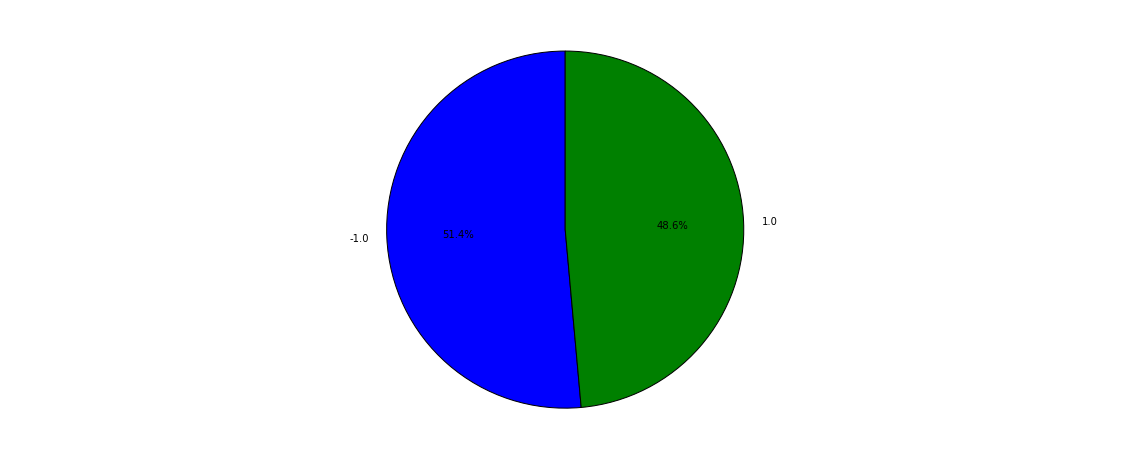

In [93]:
plt.axis('equal');
plt.pie( df_summary['price_chg_sign'].groupby(df_summary['price_chg_sign']).count(),
        startangle=90,autopct='%1.1f%%',\
        labels =df_summary['price_chg_sign'].groupby(df_summary['price_chg_sign']).count().index );
plt.show()

It shows almost 50/50 chances for the price changes going up or down in the testing period. 

How about Orbital Insights measurements?
- 102 Downward (-1)
- 108 Upward (1)

In [94]:
pd.value_counts(df_summary['oi_chg_sign'].astype(int))

 1    108
-1    102
Name: oi_chg_sign, dtype: int64

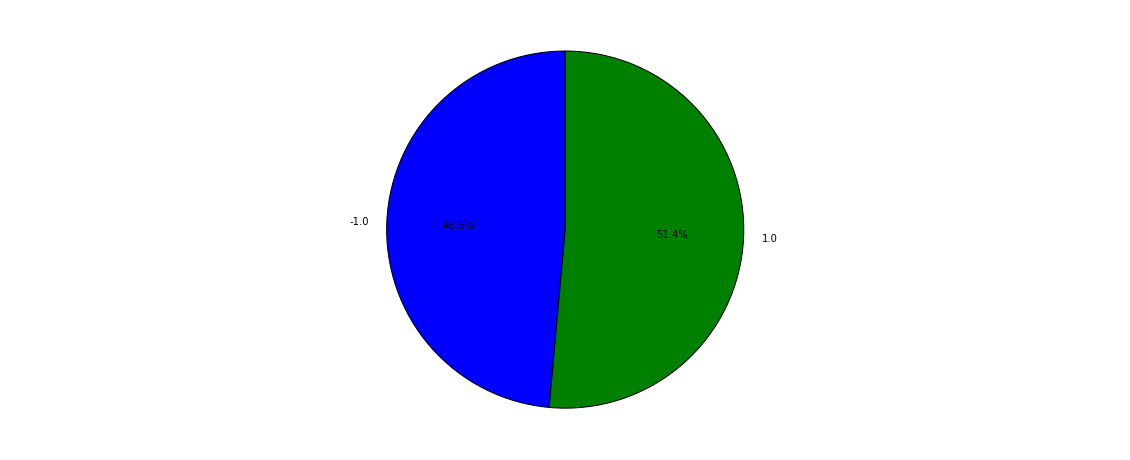

In [95]:
plt.axis('equal');
plt.pie( df_summary['oi_chg_sign'].groupby(df_summary['oi_chg_sign']).count(),
        startangle=90,autopct='%1.1f%%', 
        labels =df_summary['oi_chg_sign'].groupby(df_summary['oi_chg_sign']).count().index );
plt.show()

108 weeks out of 210 show OI average increase, 102 show decrease. It also shows that OI volume.estimate has almost 50/50 chance of increase or decrease. 

### Direction for OI Data and Settlement Price
Does the direction of Orbital Insights and settlement price correspond to each other?

In [96]:
pd.value_counts(df_summary['dir_compare'].astype(int))

 1    106
-1    104
Name: dir_compare, dtype: int64

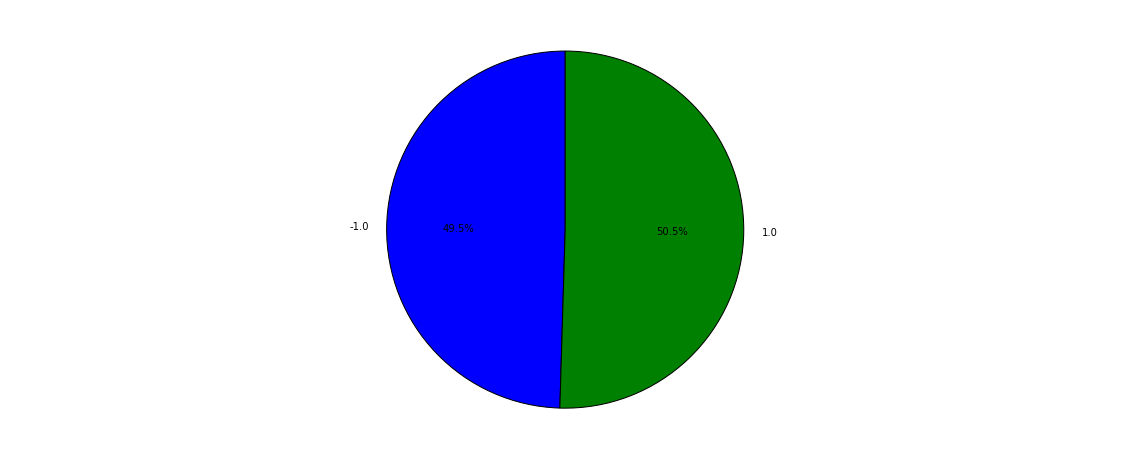

In [97]:
plt.axis('equal');
plt.pie( df_summary['dir_compare'].groupby(df_summary['dir_compare']).count(),startangle=90,autopct='%1.1f%%',
        labels =df_summary['dir_compare'].groupby(df_summary['dir_compare']).count().index );

plt.show()

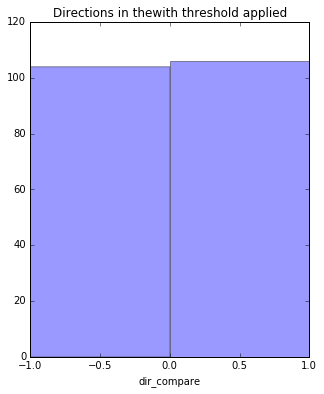

In [98]:
fig, axs = plt.subplots(figsize=(5,6));
sns.distplot(df_summary['dir_compare'].dropna(), bins=2, kde=False).set_title('Directions in thewith threshold applied');

In the dataframe above, we calculated weekly average of Orbital Insight volume estimate and tracked  price changes in 40 days for each week in the testing period. Among 210 weeks in the testing period, 106 show both volume estimate and price change move in the same direction (up or down), 104 show move in opposite direction. It seems it has almost 50/50 (50.5% vs 49.5%, exactly) chance to have price increase or decrease in 40 days regardless of the volume estimate.    

# Applying Threshold

Continuing the concept further - assume we apply filtering looking for major movements in Orbital Insights volume estimates.  Price changes after the threshold of 0.7% weekly change applied

In [99]:
pd.value_counts(df_summary['threshold_dir'].values)

-0.0    152
 1.0     34
-1.0     24
dtype: int64

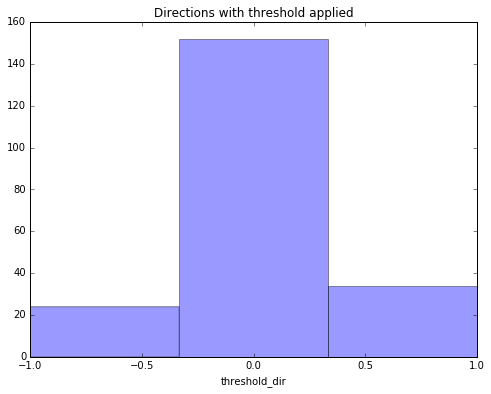

In [100]:
fig = plt.subplots(figsize=(8,6));
sns.distplot(df_summary['threshold_dir'].dropna(), bins=3, kde=False).set_title('Directions with threshold applied');

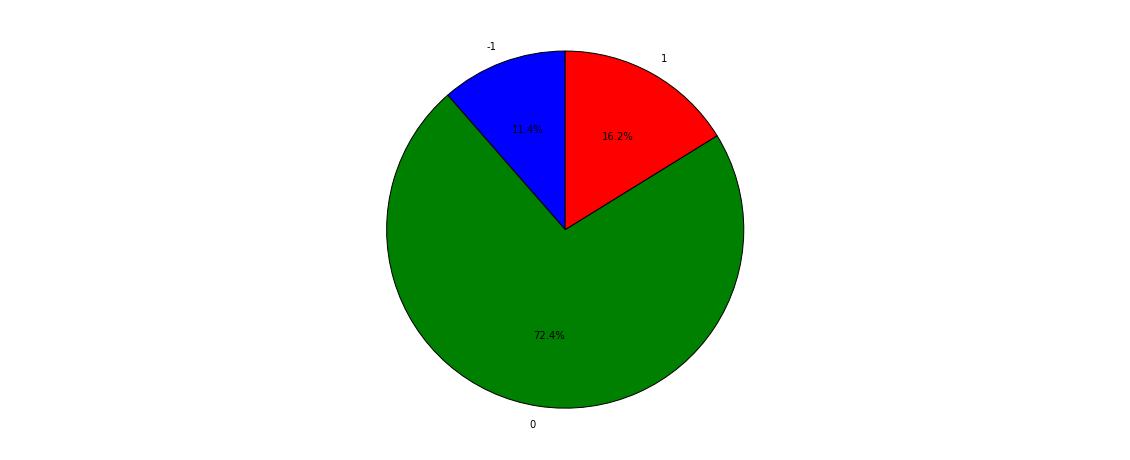

In [101]:
plt.axis('equal');
plt.pie( df_summary['threshold_dir'].groupby(df_summary['threshold_dir']).count(),startangle=90,autopct='%1.1f%%', \
        labels=df_summary['threshold_dir'].groupby(df_summary['threshold_dir'].astype(int)).count().index);

plt.show()

Out of 210 weeks in the test period, 152 weeks had volume estimate change less than the threshold. We are more interested in the other 58 weeks with significant changes. 

35 out of 58 (60%) of the weeks showed the same directions of the changes in volume estimate and crude oil prices.  

### Price Changes After Significant Volume Estimate Change

In [102]:
df_threshold = df_summary.loc[df_summary['threshold']==1]
pd.value_counts(df_threshold['dir_compare'])

 1.0    34
-1.0    24
Name: dir_compare, dtype: int64

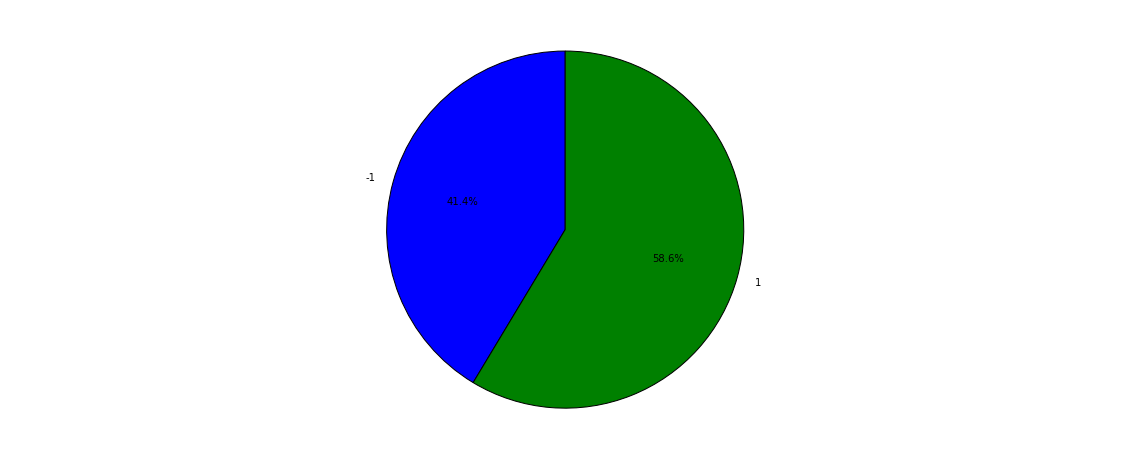

In [103]:
plt.axis('equal');
plt.pie( df_threshold['dir_compare'].groupby(df_threshold['dir_compare']).count(),startangle=90,autopct='%1.1f%%', \
        labels = df_threshold['dir_compare'].groupby(df_threshold['dir_compare'].astype(int)).count().index);

plt.show()

When threshold applied, price tends to move more in the same direction as volume estimate. The ratio moving to the same direction is now about 60% which is 10% increased from no filtering.

In [104]:
df_oi_increase = df_threshold.loc[df_threshold['oi_chg_sign']==1]
df_oi_decrease = df_threshold.loc[df_threshold['oi_chg_sign']==-1]

In [105]:
# direction comparison when volume estimate increased (1 increase, -1 decrease)
pd.value_counts(df_oi_increase['dir_compare'].astype(int))

 1    18
-1    13
Name: dir_compare, dtype: int64

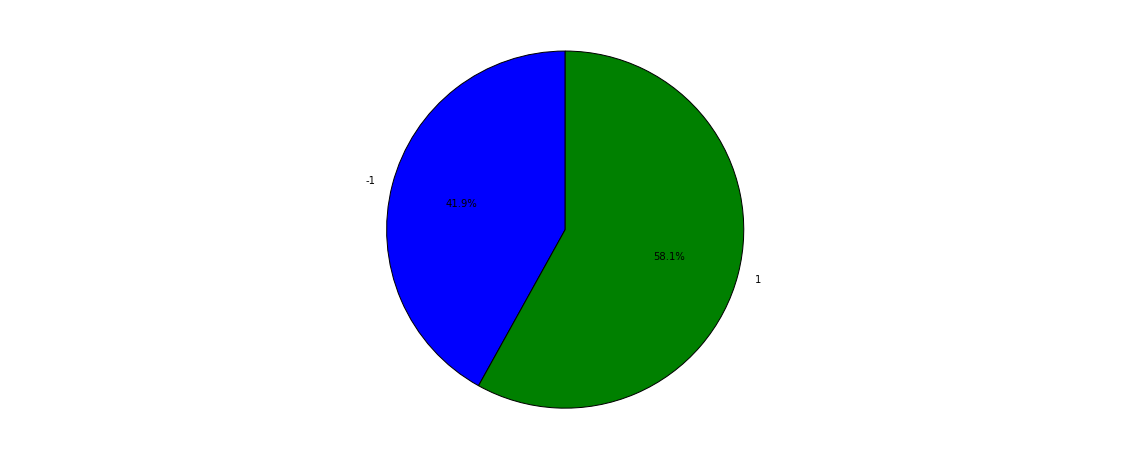

In [106]:
plt.axis('equal');
plt.pie( df_oi_increase['dir_compare'].groupby(df_oi_increase['dir_compare']).count(),
        startangle=90,autopct='%1.1f%%', 
        labels = df_oi_increase['dir_compare'].groupby(df_oi_increase['dir_compare'].astype(int)).count().index);

plt.show()

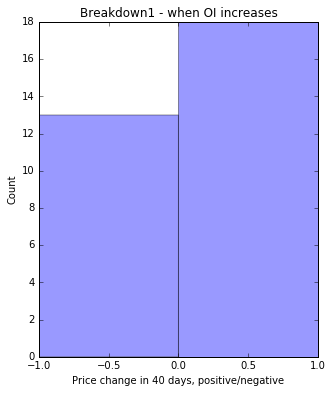

In [107]:
fig, axs = plt.subplots(figsize=(5,6));
sns.distplot(df_oi_increase['dir_compare'], 
             bins=2, 
             hist_kws={'range':(-1,1)}, kde=False, axlabel='Price change in 40 days, positive/negative')\
                                                                                .set_title('Breakdown1 - when OI increases');

axs.set_ylabel('Count');

When volume estimate significantly increased, 58.1% of the weeks show price increase in 40 days  

31 weeks showed significant storage volume increase. 18 followed by price increase (same direction) and 13 followed by decrease (opposite direction).

In [108]:
# direction comparison when volume estimate decreased
pd.value_counts(df_oi_decrease['dir_compare'].astype(int))

 1    16
-1    11
Name: dir_compare, dtype: int64

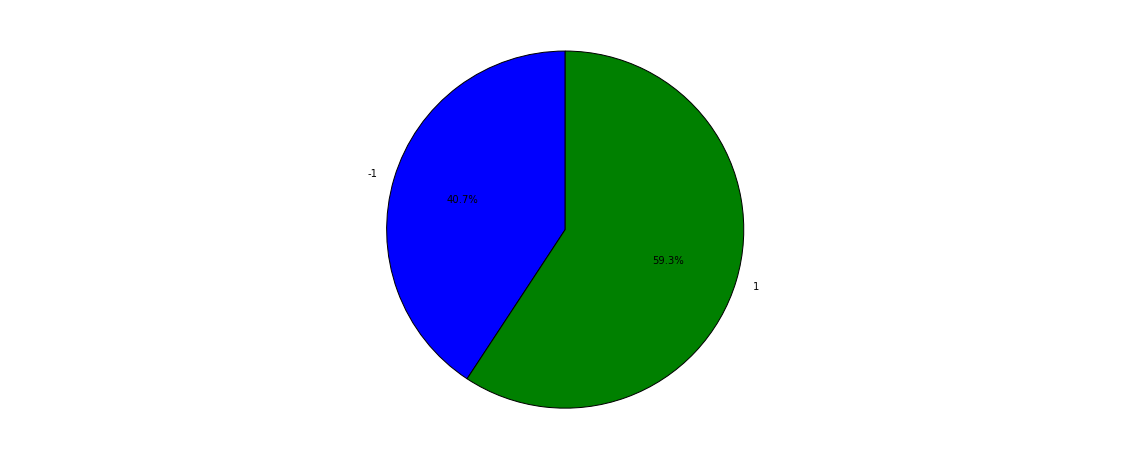

In [109]:
plt.axis('equal');
plt.pie( df_oi_decrease['dir_compare'].groupby(df_oi_decrease['dir_compare']).count(),
        startangle=90,autopct='%1.1f%%', 
        labels = df_oi_decrease['dir_compare'].groupby(df_oi_decrease['dir_compare'].astype(int)).count().index)

plt.show()

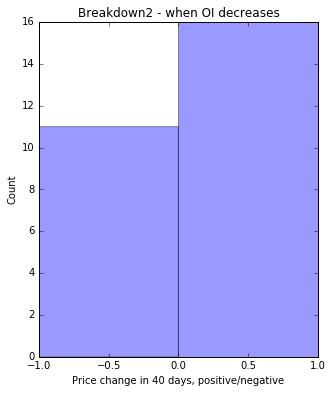

In [110]:
fig, axs = plt.subplots(figsize=(5,6));
sns.distplot(df_oi_decrease['dir_compare'], 
             bins=2, 
             hist_kws={'range':(-1,1)}, kde=False, axlabel='Price change in 40 days, positive/negative')\
                                                                                .set_title('Breakdown2 - when OI decreases');

axs.set_ylabel('Count');

When volume estimate significantly decreased, 59.3% of the weeks show price decrease in 40 days 

27 weeks showed significant storage volume decrease. 16 followed by price decrease (same direction) and 11 followed by increase (opposite direction).

## Conclusion

Crude oil futures prices are determined by various factors; storage volume is not the only factor affecting the price. However, storage volume is still one of the important factors to oil pricing and reflects information about cost of storage and oil price itself. Orbital Insight provides detailed daily volume estimates and storage capacity across more than 25,000 tanks globally.  